In [1]:
#Load the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils._mocking import CheckingClassifier

from sklearn.linear_model import RidgeClassifierCV
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

#load the helping functions
from pipeline_functions import replace_inf_with_nans, standadize_cols_per_subject, replace_with_nan
from pipeline_functions import impute_per_subject,replace_with_ceiling, get_feature_matrix, get_feature_matrix_with_labels
from pipeline_functions import get_frequent_features, get_stats_for_elbow_curve, get_optimal_features_and_methods

In [2]:
#Load the data and drop the left pupil
subjects_with_conditions_df = pd.read_csv('../subjects_with_conditions_df.csv').drop('Unnamed: 0', axis = 1).drop('left_pupil', axis = 1)

In [3]:
#Data curation- remove subject 1009 since it has 60% broken trials
subjects_with_conditions_df = subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']!= 1009]

In [4]:
subjects_with_conditions_df

,subject,sample,time,trial,currentobject,rt,right_pupil,right_gaze_x,right_gaze_y,left_gaze_x,left_gaze_y,goal,feedback,reward,bi_goal,bi_feedback,bi_reward,tir_goal,tir_reward,label_7
0,845,1,342413,1,Timer,284,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
1,845,2,342421,1,Timer,284,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
2,845,3,342430,1,Timer,284,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
3,845,4,342439,1,Timer,284,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
4,845,5,342446,1,Timer,284,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62611723,1246,180655,1944419,140,Feedback,324,3.167541,0.551039,0.559055,0.551768,0.445488,2,1,0,NaN,NaN,0.0,NaN,0.0,4
62611724,1246,180656,1944428,140,Feedback,324,3.051903,0.555099,0.519198,0.547411,0.424676,2,1,0,NaN,NaN,0.0,NaN,0.0,4
62611725,1246,180657,1944436,140,Feedback,324,2.952341,0.558744,0.487035,0.548020,0.400561,2,1,0,NaN,NaN,0.0,NaN,0.0,4
62611726,1246,180658,1944444,140,Feedback,324,3.112280,0.552730,0.532222,0.548947,0.431200,2,1,0,NaN,NaN,0.0,NaN,0.0,4


In [5]:
#len(subjects_with_conditions_df.loc[subjects_with_conditions_df['label_7']==4]['subject'].unique().tolist())

In [6]:
#Data curation- use the ceiling value for RT and gazes to limit high values

ceiling_df = replace_with_ceiling(subjects_with_conditions_df)

In [7]:
#Feature engineering - Adding the Deviation feature to the df

ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2) 
ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2) 

In [8]:
#Feature engineering- Taking means and variances

FE_df =  ceiling_df.groupby(['subject', 'trial']).agg({'right_pupil': ['mean', 'var'], 'LDEV': ['mean', 'var'], 
                                                       'RDEV': ['mean', 'var'],'rt': 'mean' }).reset_index()

In [9]:
# Data imputation

imputed_df = impute_per_subject(FE_df)

In [10]:
#Data standardization. This is done per subject

standardized_df = standadize_cols_per_subject(imputed_df)


/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Classification/pipeline_functions.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df[columns[j]] = scaler.fit_transform(subject_df[columns[j]].values.reshape(-1,1))
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Classification/pipeline_functions.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [11]:
#Get the feature matrix

Feature_matrix_df = get_feature_matrix(standardized_df)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [12]:
Feature_matrix_with_labels =  get_feature_matrix_with_labels(subjects_with_conditions_df, Feature_matrix_df)

In [13]:
Feature_matrix_with_labels.head()

,1,2,3,4,5,6,7,8,9,10,...,977,978,979,980,bi_goal,bi_feedback,bi_reward,tir_goal,tir_reward,label_7
845.0,0.718531,0.655245,0.327336,0.443157,0.336879,0.213414,0.216704,0.673229,0.465331,0.445478,...,0.202381,0.257937,0.265873,0.634921,1.0,NaN,NaN,2.0,NaN,3
846.0,0.890184,0.876509,0.525048,0.703541,0.541176,0.513490,0.533830,0.441735,0.787322,0.838608,...,0.258575,0.147757,0.142480,0.121372,1.0,NaN,NaN,1.0,NaN,2
847.0,0.357387,0.297813,0.802681,0.543541,0.673288,0.435294,0.500908,0.981565,0.014090,0.366399,...,0.262222,0.324444,0.106667,0.384444,0.0,0.0,NaN,0.0,NaN,0
848.0,0.423918,0.421592,0.352956,0.318847,0.323888,0.300182,0.366398,0.274508,0.325481,0.398756,...,0.703316,0.493892,0.757417,0.530541,1.0,NaN,NaN,2.0,NaN,3
849.0,0.571958,0.408893,0.395655,0.520751,0.437383,0.340203,0.337662,0.331084,0.292554,0.279469,...,0.104587,0.218349,0.121101,0.163303,1.0,NaN,NaN,1.0,NaN,2


In [14]:
#get the aic bic optimal alphas fot lassolarsIC
def get_aic_bic_coefs_and_alphas(df):
    from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
    import time
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.iloc[:, 0:980]
    aic_coefficients =  []
    bic_coefficients = []
    aic_alphas = []
    bic_alphas = []
    for i in range(6):
        label_series = df[label_list[i]]
        problem_df1 = pd.concat([feature_df, label_series], axis =1) 
        problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
        X = problem_df2.iloc[:, 0:980]
        X= X.astype('float')
        Y = problem_df2[label_list[i]]
        Y= Y.astype('int')

        model_bic = LassoLarsIC(criterion='bic')
        t1 = time.time()
        bic_model = model_bic.fit(X, Y)
        t_bic = time.time() - t1
        alpha_bic = model_bic.alpha_

        bic_coefficients.append(bic_model.coef_.tolist())
        bic_alphas.append(alpha_bic)

        model_aic = LassoLarsIC(criterion='aic')
        aic_model = model_aic.fit(X, Y)
        alpha_aic = model_aic.alpha_

        aic_coefficients.append(aic_model.coef_.tolist())
        aic_alphas.append(alpha_aic)
        
    return aic_coefficients, bic_coefficients , aic_alphas, bic_alphas
    

In [15]:
aic_coefficients, bic_coefficients , aic_alphas, bic_alphas = get_aic_bic_coefs_and_alphas(Feature_matrix_with_labels)

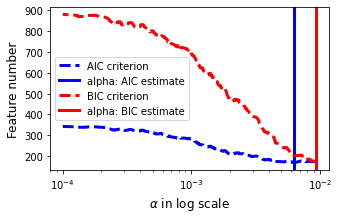

In [26]:
#Plotting AIC and BIC
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import time
df = Feature_matrix_with_labels
k=1
if k==1:
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.iloc[:, 0:980]
    aic_coefficients =  []
    bic_coefficients = []
    aic_alphas = []
    bic_alphas = []
    for i in range(1):
        label_series = df[label_list[i]]
        problem_df1 = pd.concat([feature_df, label_series], axis =1) 
        problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
        X = problem_df2.iloc[:, 0:980]
        X= X.astype('float')
        Y = problem_df2[label_list[i]]
        Y= Y.astype('int')

        model_bic = LassoLarsIC(criterion='bic')
        t1 = time.time()
        bic_model = model_bic.fit(X, Y)
        t_bic = time.time() - t1
        alpha_bic = model_bic.alpha_

        bic_coefficients.append(bic_model.coef_.tolist())
        bic_alphas.append(alpha_bic)

        model_aic = LassoLarsIC(criterion='aic')
        aic_model = model_aic.fit(X, Y)
        alpha_aic = model_aic.alpha_

        aic_coefficients.append(aic_model.coef_.tolist())
        aic_alphas.append(alpha_aic)
        
def plot_ic_criterion(model, name, color):
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$ in log scale', fontsize = 12)
    plt.ylabel('Feature number', fontsize = 12)


plt.figure(figsize= (5, 3))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
#plt.title('Information-criterion for model selection (training time %.3fs)'
          #% t_bic)
#figure.tight_layout() 
plt.savefig('aic bic for bi_goal.pdf')

In [16]:
#Getting the optimal alpha and l_1 ratio for elasticnetc using elasticnetcv

def get_alpha_and_l1_for_elasticnet(df):
    from sklearn.linear_model import ElasticNetCV
    from sklearn.linear_model import RidgeClassifierCV
    
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.iloc[:, 0:980]
    elas_alphas = []
    elas_l1 = []
    for i in range(6):
        label_series = df[label_list[i]]
        problem_df1 = pd.concat([feature_df, label_series], axis =1) 
        problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
        X = problem_df2.iloc[:, 0:980]
        X= X.astype('float')
        Y = problem_df2[label_list[i]]
        Y= Y.astype('int')

        #model = ElasticNetCV(l1_ratio= [.1,.5,.7,.9,.95, .99, 1], n_alphas= 100, cv= 5, random_state=1000)
        model = ElasticNetCV(l1_ratio= [.01, .05, .1,.5,.7,.9], n_alphas= 100, cv= 5, random_state=1000)
        model.fit(X, Y)
        elas_alphas.append(model.alpha_)
        elas_l1.append(model.l1_ratio_)
        
    return elas_alphas, elas_l1
    

In [17]:
elas_alphas, elas_l1 = get_alpha_and_l1_for_elasticnet(Feature_matrix_with_labels)

In [18]:
elas_alphas

[0.23905405663983317,
 2.625379714225856,
 0.7611808492322564,
 4.051001995212966,
 0.03590426774859214,
 0.15717212377472647]

In [19]:
elas_l1

[0.1, 0.01, 0.01, 0.01, 0.9, 0.1]

In [20]:
#trying the elasticnet aplhas with elasticnet
def get_elasticnet_features(df,elas_alphas, elas_l1):

    from sklearn.linear_model import ElasticNet
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.iloc[:, 0:980]
    elasti_feature_list = [] 
    elasti_no_of_features = []
    
    for j in range(1):
        for i in range(6):
            label_series = df[label_list[i]]
            problem_df1 = pd.concat([feature_df, label_series], axis =1) 
            problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
            X = problem_df2.iloc[:, 0:980]
            X= X.astype('float')
            Y = problem_df2[label_list[i]]
            Y= Y.astype('int')

            #model = ElasticNet(alpha = elas_alphas[i], l1_ratio= elas_l1[i], random_state=1000)
            model = ElasticNet(alpha = elas_alphas[i], l1_ratio= 0, random_state=1000)
            model.fit(X, Y)
            coefs = model.coef_.tolist()


            no_of_features = len([x for x in coefs if x != 0]) #counts the number of non zero coefficients
            sorted_score_list = np.argsort(-np.array(coefs), kind='mergesort') #this gives the indices of the highest element to the lowest element
            feature_indices = sorted_score_list[0:no_of_features ]
            elasti_feature_list.append([x+1 for x in feature_indices]) #because indices are one less the actual feature 
            elasti_no_of_features.append(no_of_features)
            
    return elasti_feature_list, elasti_no_of_features        

In [21]:
elasti_feature_list, elasti_no_of_features = get_elasticnet_features(Feature_matrix_with_labels, elas_alphas, elas_l1)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.91359498035785, tolerance: 0.004111627906976744
  model = cd_fast.enet_coordinate_descent(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.163780829718759, tolerance: 0.0022666666666666664
  model = cd_fast.enet_coordinate_descent(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.402045441048841, tolerance: 0.0035748251748251793
  model = cd_fast.enet_coord

In [22]:
elasti_no_of_features

[980, 980, 980, 980, 980, 980]

In [23]:
np.save('elasti_feature_list', elasti_feature_list, allow_pickle= True, fix_imports= True)

In [24]:
#Getting the lassolarsIC feature list
def get_features_and_no_of_features(aic_coefficients, bic_coefficients):
    #Normalize the list
    def normalize(list1):
        if sum(list1)== 0:
            new_list = list1
        else:
            norm = np.linalg.norm(list1)
            new_list = [abs(x/norm) for x in list1]
        return new_list
    
    #Normalize the coeficients
    normlzd_aic_coef = []
    normlzd_bic_coef = []
    for i in range(6):
        normlzd_aic_coef.append(normalize(list(map(abs,aic_coefficients[i]))))
        normlzd_bic_coef.append(normalize(list(map(abs,bic_coefficients[i]))))
        
    #get the features   
    feature_list = []
    no_of_features_list = []
    for i in range(6):
    
        score_list = [(g + h) for g, h in zip(normlzd_aic_coef[i], normlzd_bic_coef[i])] #giving a score to each feature
        no_of_features = len([x for x in score_list if x != 0]) #counts the number of non zero coefficients
        sorted_score_list = np.argsort(-np.array(score_list), kind='mergesort') #this gives the indices of the highest element to the lowest element
        feature_indices = sorted_score_list[0:no_of_features ]
        feature_list.append([x+1 for x in feature_indices]) #because indices are one less the actual feature 
        no_of_features_list.append(no_of_features)

    return feature_list, no_of_features_list
    

In [25]:
#get the number of features and the features using aic, bic
feature_list, no_of_features_list = get_features_and_no_of_features(aic_coefficients, bic_coefficients)    

In [26]:
no_of_features_list

[11, 1, 4, 1, 3, 5]

In [27]:
#np.save('lasso_feature_list',feature_list, allow_pickle= True, fix_imports= True)

In [28]:
#np.save('lasso_no_of_features_list', no_of_features_list, allow_pickle= True, fix_imports= True)

In [29]:
#lasso_feature_list = np.load('lasso_no_of_features_list.npy', allow_pickle= True, fix_imports= True)

In [30]:
#lasso_no_of_features_list

In [31]:
#Gluing the Lasso and ELasticNet features to get the best number of features and methods
def get_lasso_elast_features(feature_list, elasti_feature_list):
    def get_clean_set(seq):
            seen = set()
            seen_add = seen.add
            return [x for x in seq if not (x in seen or seen_add(x))]

    lasso_elasti_features = []
    for i in range(6):
        c = feature_list[i]
        b = elasti_feature_list[i][0:2] 
        c.extend(b) #glue the first 25 features of elasti to the back of lasso. Now the feature_list is changed. This has repititions
        lasso_elasti_features.append(get_clean_set(c))
        
    return lasso_elasti_features


In [32]:
lasso_elasti_features = get_lasso_elast_features(feature_list, elasti_feature_list) #extended feature list

In [33]:
#len(lasso_elasti_features[5])

In [34]:
np.save('lasso_elasti_features', lasso_elasti_features, allow_pickle= True, fix_imports= True)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [35]:
def get_stats_for_elbow_curve_new(df, feature_list):

    from sklearn.model_selection import train_test_split
    balanced_accuracy_df_list = [] #This list will have the balanced accuracy df's for the 6 problems
    from Lazy_predict_version_Nethali_new1 import Classification
    #%load_ext line_profiler
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    accuracy_dict_list = []
    aic_dict_list = []
    
    for k in range(1):
        for c in range(6):
            features_for_problem = feature_list[c]
            accuracy_dict_for_problem = {}
            aic_dict_for_problem = {}
            label_series = df[label_list[c]] 
            for j in range(len(features_for_problem)):
                feature_index_list = [x-1 for x in features_for_problem[0:j+1]] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
                balanced_accuracy_for_problem_df_list1 = [] #this is specific to a given j
                aic_for_problem_df_list2 = []
                problem_df = df.iloc[:,feature_index_list] #this needs to be changed to pick one feature at a time [0: len(feat)], the new feature matrix 7/5
                
                #This is for a particular j no of features
                
                for i in range(5): #This is for manual cv
                    random_state = [42, 35, 68, 92, 70] 
                    #random_state = [42, 35, 68, 92, 80] 
                   
                    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
                    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
                    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
                    X= X.astype('float')
                    Y = problem_df2[label_list[c]]
                    Y= Y.astype('int')
                    
                    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
                    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
                    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
                    balanced_accuracy_for_problem_df_list1.append(models.drop(['AIC', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"Accuracy":str(i)}))
                    aic_for_problem_df_list2.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"AIC":str(i)}))
                #get the resulting concat df
                result_df1 = pd.concat(balanced_accuracy_for_problem_df_list1, axis=1)
                result_df2 = pd.concat(aic_for_problem_df_list2, axis=1)
                #get the lowest median for df2 and highest accuracy for df1
                accuracy_dict_for_problem[str(j+1)+'features'] = (result_df1.mean(axis= 1).max(), 
                                                                result_df1.mean(axis= 1).idxmax())
                aic_dict_for_problem[str(j+1)+'features'] = (result_df2.mean(axis= 1).min(), 
                                                                result_df2.mean(axis= 1).idxmin())
            accuracy_dict_list.append(accuracy_dict_for_problem)
            aic_dict_list.append(aic_dict_for_problem)
    return accuracy_dict_list , aic_dict_list 

In [36]:
#Get the accuracy and methods for 15 features added subsequntly to create an elbow curve
accuracy_dict_list,aic_dict_list =  get_stats_for_elbow_curve_new(Feature_matrix_with_labels, lasso_elasti_features) #Need to use the extended features here

 76%|███████▌  | 22/29 [00:00<00:00, 59.07it/s]

[12:30:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.14it/s]

[12:30:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.86it/s]

[12:30:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.50it/s]

[12:30:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.52it/s]

[12:30:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.06it/s]

[12:30:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.68it/s]

[12:30:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.32it/s]

[12:30:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.22it/s]

[12:30:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 55.87it/s]

[12:30:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.10it/s]

[12:30:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.99it/s]

[12:30:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.16it/s]

[12:30:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.01it/s]

[12:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.68it/s]

[12:30:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.84it/s]

[12:30:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 25.63it/s]

[12:30:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 38.26it/s]

[12:30:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.01it/s]

[12:30:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.55it/s]

[12:30:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.69it/s]

[12:30:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.74it/s]

[12:30:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 35.88it/s]

[12:30:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 40.26it/s]

[12:30:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.41it/s]

[12:30:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.64it/s]

[12:30:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.80it/s]

[12:30:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.26it/s]

[12:30:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.25it/s]

[12:30:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.72it/s]

[12:30:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 45.15it/s]

[12:30:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.95it/s]

[12:30:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 29.23it/s]

[12:30:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 41.17it/s]

[12:30:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.25it/s]

[12:30:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 38.75it/s]

[12:30:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 44.89it/s]

[12:30:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 32.14it/s]

[12:30:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 23.97it/s]

[12:30:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 32.88it/s]

[12:30:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 37.63it/s]

[12:31:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 35.51it/s]

[12:31:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.01it/s]

[12:31:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.90it/s]

[12:31:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.79it/s]

[12:31:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 32.61it/s]

[12:31:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 38.25it/s]

[12:31:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 43.60it/s]

[12:31:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.20it/s]

[12:31:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 55.98it/s]

[12:31:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 45.62it/s]

[12:31:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.16it/s]

[12:31:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.84it/s]

[12:31:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 45.47it/s]

[12:31:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:01<00:00, 22.69it/s]

[12:31:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.39it/s]

[12:31:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.62it/s]

[12:31:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 36.08it/s]

[12:31:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.74it/s]

[12:31:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.95it/s]

[12:31:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.18it/s]

[12:31:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.36it/s]

[12:31:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.42it/s]

[12:31:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 43.45it/s]

[12:31:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.64it/s]

[12:31:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 44.78it/s]

[12:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 46.44it/s]

[12:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 31.59it/s]

[12:31:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.39it/s]

[12:31:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 30.19it/s]

[12:31:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.91it/s]

[12:31:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.36it/s]

[12:31:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.88it/s]

[12:31:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.77it/s]

[12:32:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.96it/s]

[12:32:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.58it/s]

[12:32:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.56it/s]

[12:32:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.54it/s]

[12:32:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.35it/s]

[12:32:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.58it/s]

[12:32:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 38.40it/s]

[12:32:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.58it/s]

[12:32:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.75it/s]

[12:32:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 33.41it/s]

[12:32:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 27.42it/s]

[12:32:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 37.41it/s]

[12:32:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.95it/s]

[12:32:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.79it/s]

[12:32:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.78it/s]

[12:32:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.03it/s]

[12:32:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.07it/s]

[12:32:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.75it/s]

[12:32:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 28.86it/s]

[12:32:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.98it/s]

[12:32:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 37.14it/s]

[12:32:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.02it/s]

[12:32:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.18it/s]

[12:32:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.40it/s]

[12:32:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.79it/s]

[12:32:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.34it/s]

[12:32:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.05it/s]

[12:32:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.47it/s]

[12:32:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.40it/s]

[12:32:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.50it/s]

[12:33:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.11it/s]

[12:33:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.38it/s]

[12:33:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.20it/s]

[12:33:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.71it/s]

[12:33:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.17it/s]

[12:33:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.18it/s]

[12:33:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.94it/s]

[12:33:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.00it/s]

[12:33:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.23it/s]

[12:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.73it/s]

[12:33:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.87it/s]

[12:33:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.49it/s]

[12:33:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.74it/s]

[12:33:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.00it/s]

[12:33:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.69it/s]

[12:33:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.76it/s]

[12:33:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 41.02it/s]

[12:33:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.78it/s]

[12:33:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.24it/s]

[12:33:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.52it/s]

[12:33:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.33it/s]

[12:33:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.38it/s]

[12:33:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.21it/s]

[12:33:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.70it/s]

[12:33:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.27it/s]

[12:33:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.03it/s]

[12:33:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.57it/s]

[12:33:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 67.21it/s]

[12:33:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 67.38it/s]

[12:34:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 68.09it/s]

[12:34:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 69%|██████▉   | 20/29 [00:00<00:00, 65.55it/s]

[12:34:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 53.49it/s]

[12:34:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.19it/s]

[12:34:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.21it/s]

[12:34:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.41it/s]

[12:34:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.50it/s]

[12:34:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 53.92it/s]

[12:34:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.11it/s]

[12:34:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.75it/s]

[12:34:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 51.00it/s]

[12:34:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 51.21it/s]

[12:34:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 45.08it/s]

[12:35:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 44.18it/s]

[12:35:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.40it/s]

[12:35:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.26it/s]

[12:35:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 52.50it/s]

[12:35:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 44.75it/s]

[12:35:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.81it/s]

[12:35:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 48.43it/s]

[12:35:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.92it/s]

[12:35:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 43.89it/s]

[12:36:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 44.73it/s]

[12:36:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 43.85it/s]

[12:36:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.89it/s]

[12:36:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 44.19it/s]

[12:36:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 44.52it/s]

[12:36:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:04<00:00,  6.02it/s]


In [59]:
np.save('accuracy_dict',accuracy_dict_list, allow_pickle= True, fix_imports= True)
np.save('aic_dict',aic_dict_list, allow_pickle= True, fix_imports= True)

In [60]:
accuracy_dict_list

[{'1features': (0.6457142857142857, 'LogisticRegression'),
  '2features': (0.6857142857142857, 'SGDClassifier'),
  '3features': (0.6971428571428572, 'SVC'),
  '4features': (0.7485714285714287, 'RidgeClassifierCV'),
  '5features': (0.7542857142857143, 'LinearDiscriminantAnalysis'),
  '6features': (0.76, 'RidgeClassifierCV'),
  '7features': (0.7485714285714286, 'SVC'),
  '8features': (0.7828571428571429, 'SGDClassifier'),
  '9features': (0.76, 'LinearDiscriminantAnalysis'),
  '10features': (0.7657142857142858, 'RidgeClassifierCV'),
  '11features': (0.7828571428571429, 'RidgeClassifierCV')},
 {'1features': (0.7714285714285715, 'GaussianNB'),
  '2features': (0.7809523809523808, 'RidgeClassifier'),
  '3features': (0.7904761904761906, 'LinearDiscriminantAnalysis')},
 {'1features': (0.6482758620689655, 'LabelPropagation'),
  '2features': (0.7034482758620689, 'QuadraticDiscriminantAnalysis'),
  '3features': (0.6620689655172415, 'NearestCentroid'),
  '4features': (0.7103448275862069, 'LinearSVC

In [61]:
aic_dict_list

[{'1features': (-331.2585351965296, 'LogisticRegression'),
  '2features': (-346.48241246470263, 'SGDClassifier'),
  '3features': (-352.5558427891424, 'SVC'),
  '4features': (-374.9062988338783, 'RidgeClassifierCV'),
  '5features': (-375.1614486922848, 'LinearDiscriminantAnalysis'),
  '6features': (-374.85185248303117, 'RidgeClassifierCV'),
  '7features': (-366.85976837659484, 'SVC'),
  '8features': (-387.4599735008577, 'SGDClassifier'),
  '9features': (-366.24314933212077, 'LinearDiscriminantAnalysis'),
  '10features': (-369.80372845763003, 'RidgeClassifierCV'),
  '11features': (-375.4678893944214, 'RidgeClassifierCV')},
 {'1features': (-229.23496036479622, 'NearestCentroid'),
  '2features': (-231.6402865556312, 'RidgeClassifier'),
  '3features': (-237.66053827775642, 'LinearDiscriminantAnalysis')},
 {'1features': (-273.7171457310323, 'LabelPropagation'),
  '2features': (-293.0810205779052, 'QuadraticDiscriminantAnalysis'),
  '3features': (-276.33792121761405, 'CalibratedClassifierCV')

In [62]:
def get_best_features_methods(accuracy_dict_list, aic_dict_list):
    best_accuracies = []
    best_aics = []
    no_of_best_accuracy_features = []
    no_of_best_aic_features = []
    for i in range(6):
        
        #Get the best accuracy
        accuracy_dict = accuracy_dict_list[i]
        #get the first occurence of the highest value (its index)
        accuracies_list = [x for (x,y) in accuracy_dict.values()]
        best_accu_index = np.argmax(accuracies_list) #the first occurence of the max bal.accu
        no_of_best_accuracy_features.append(best_accu_index+1) #This is the number of features
        best_accuracies.append(list(accuracy_dict.items())[best_accu_index])
        
        #get the best aic
        aic_dict = aic_dict_list[i]
        #get the first occurence of the highest value (its index)
        aics_list = [x for (x,y) in aic_dict.values()]
        best_aic_index = np.argmin(aics_list) #the first occurence of the min aic
        no_of_best_aic_features.append(best_aic_index+1) #This is the number of features
        best_aics.append(list(aic_dict.items())[best_aic_index])
        
    return no_of_best_accuracy_features, no_of_best_aic_features, best_accuracies, best_aics

In [63]:
no_accu_features, no_aic_features, best_accuracies, best_aics = get_best_features_methods(accuracy_dict_list, aic_dict_list)

In [64]:
best_aics

[('8features', (-387.4599735008577, 'SGDClassifier')),
 ('3features', (-237.66053827775642, 'LinearDiscriminantAnalysis')),
 ('5features', (-302.88477629467195, 'CalibratedClassifierCV')),
 ('1features', (-284.5549620554878, 'RidgeClassifier')),
 ('5features', (-254.2595342133428, 'LinearSVC')),
 ('5features', (-469.74257371577096, 'LinearSVC'))]

In [43]:
#best_aics

In [65]:
no_accu_features

[8, 3, 5, 2, 5, 5]

In [66]:
no_aic_features

[8, 3, 5, 1, 5, 5]

In [67]:
best_accuracies

[('8features', (0.7828571428571429, 'SGDClassifier')),
 ('3features', (0.7904761904761906, 'LinearDiscriminantAnalysis')),
 ('5features', (0.7448275862068965, 'QuadraticDiscriminantAnalysis')),
 ('2features', (0.52, 'CalibratedClassifierCV')),
 ('5features', (0.6068965517241379, 'LinearSVC')),
 ('5features', (0.28285714285714286, 'RidgeClassifierCV'))]

In [68]:
lasso_elasti_features[5]

[57, 789, 858, 738, 514, 246]

# Running the methods manually for MAM and MIM

In [69]:
#FOR MAM
#Getting the feature matrix X and label series, Y for c problem

#def get_feature_mat_for_para_tune(df, feature_list, best_features_methods, c): #c should be the problem number -1

def get_feature_mat_for_para_tune(df, feature_list, c):

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    #no_of_features = best_features_methods[c][1] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    #no_of_features = [8, 2, 4, 2, 5, 15] #balanced accuracy features
    no_of_features = [8, 3, 5, 2, 5, 5] #balanced accuracy features
    
    features_for_problem = feature_list[c][0:no_of_features[c]] #get the correct features
    feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
    label_series = df[label_list[c]]  

    problem_df = df.iloc[:,feature_index_list]
    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
    X= X.astype('float')
    Y = problem_df2[label_list[c]]
    Y= Y.astype('int')
    return X, Y

In [70]:
#FOR MAM
#Getting the balanced accuracies by running the methods manually
from statistics import stdev
from sklearn.svm import NuSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import zero_one_loss, make_scorer
z1_scorer = make_scorer(zero_one_loss, normalize = False)
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.semi_supervised import LabelSpreading

balanced_accuracies_list = []
std_of_accuracy_list = []
aic_list = []
clf_list = [SGDClassifier(), LinearDiscriminantAnalysis(), CalibratedClassifierCV(), RidgeClassifier(), LinearSVC(), LinearSVC()   ]#bal.acc

#clf_list = [SGDClassifier(), GaussianNB(), LinearSVC(), RidgeClassifier(), LinearDiscriminantAnalysis(), CalibratedClassifierCV()]
for i in range(6):
    #X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, best_features_methods, i)
    X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, i)
    clf = clf_list[i]
    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
    cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
    balanced_accuracy = cv_results['test_score'].mean()
    std_of_accuracy = stdev(cv_results['test_score'])
    balanced_accuracies_list.append(balanced_accuracy)
    std_of_accuracy_list.append( std_of_accuracy )
    
    cv_results2 = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
    z1_mean = cv_results2['test_score'].mean()
    splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
    n_train_samples = len(splits[0][0]) #this will give the train sample length
    aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
    aic_list.append(aic)

In [71]:
balanced_accuracies_list

[0.6921875,
 0.6308333333333332,
 0.7004166666666666,
 0.4321527777777778,
 0.44993055555555556,
 0.21074404761904758]

In [51]:
#balanced_accuracies_list

In [72]:
std_of_accuracy_list # (best accuracy)

[0.14722760360036008,
 0.19652367258096867,
 0.17858347216417994,
 0.1153356388694666,
 0.13322042742918497,
 0.06187789605641405]

In [73]:
aic_list

[-659.7916107053375,
 -404.44002236309984,
 -549.0310044808912,
 -595.1020653949129,
 -496.2455647226596,
 -1079.42041379931]

In [74]:
#FOR MIM

#Getting the feature matrix X and label series, Y for c problem

#def get_feature_mat_for_para_tune(df, feature_list, best_features_methods, c): #c should be the problem number -1

def get_feature_mat_for_para_tune(df, feature_list, c):

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    #no_of_features = best_features_methods[c][1] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    
    no_of_features = [8, 3, 5, 1, 5, 5] #aic features
    features_for_problem = feature_list[c][0:no_of_features[c]] #get the correct features
    feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
    label_series = df[label_list[c]]  

    problem_df = df.iloc[:,feature_index_list]
    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
    X= X.astype('float')
    Y = problem_df2[label_list[c]]
    Y= Y.astype('int')
    return X, Y

In [75]:
#FOR MIM
#Getting the balanced accuracies by running the methods manually
from statistics import stdev
from sklearn.svm import NuSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss, make_scorer
z1_scorer = make_scorer(zero_one_loss, normalize = False)

balanced_accuracies_list_mim = []
std_of_accuracy_list_mim = []
aic_list= []
clf_list = [SGDClassifier(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), CalibratedClassifierCV(), LinearSVC(), RidgeClassifierCV()   ]#bal.acc

#clf_list = [SGDClassifier(), NearestCentroid(), LinearSVC(), RidgeClassifier(), RidgeClassifierCV(), CalibratedClassifierCV()]
for i in range(6):
    #X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, best_features_methods, i)
    X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, i)
    clf = clf_list[i]
    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
    cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
    balanced_accuracy = cv_results['test_score'].mean()
    std_of_accuracy = stdev(cv_results['test_score'])
    balanced_accuracies_list_mim.append(balanced_accuracy)
    std_of_accuracy_list_mim.append( std_of_accuracy )
    
    cv_results2 = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
    z1_mean = cv_results2['test_score'].mean()
    splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
    n_train_samples = len(splits[0][0]) #this will give the train sample length.
    #Here the first 0 provides the train test indices of the first cv. The second 0 is to get train indices. 
    #Change the second 0 to 1 to get the idices of the training set of the first cv iteration
    aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
    aic_list.append(aic)

In [76]:
balanced_accuracies_list_mim 

[0.6944791666666668,
 0.6308333333333332,
 0.7025,
 0.4121527777777778,
 0.44993055555555556,
 0.21363095238095237]

In [77]:
aic_list

[-664.4376254723079,
 -404.44002236309984,
 -550.135627826808,
 -588.7363250703552,
 -496.2455647226596,
 -1081.5776515776838]

In [78]:
std_of_accuracy_list #(for aic)

[0.14722760360036008,
 0.19652367258096867,
 0.17858347216417994,
 0.1153356388694666,
 0.13322042742918497,
 0.06187789605641405]

# Parameter tuning (and improving balanced accuracy with higher number of features)

In [79]:
#Getting the feature matrix X and label series, Y for c problem
#This will update all the problems' features as per features per problem. However, in the next code
#set i to check for the particular 


def get_feature_mat_for_para_tune(df, feature_list, c):

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    #no_of_features = best_features_methods[c][1] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    #no_of_features = [3, 2, 6, 4, 7, 5] #balanced accuracy features
    #no_of_features = [1, 2, 3, 1, 2, 1] #aic features
    #no_of_features = [4, 3, 10, 5, 12, 38] #full number of features
    no_of_features = [8,3,5,2,5,5] #choice number of features
    
    
    #Change c here to get the right features
    #features_for_problem1 = feature_list[c][0: no_of_features[c]] #get the correct features
    features_for_problem1 = feature_list[1][0:3] #get the correct features
    features_for_problem2 = feature_list[4][0:5] #get the correct features
    features_for_problem3 = feature_list[5][0:5]
    features_for_problem = features_for_problem1  + features_for_problem2 + features_for_problem3
    
    
    feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
    label_series = df[label_list[c]]  

    problem_df = df.iloc[:,feature_index_list]
    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
    X= X.astype('float')
    Y = problem_df2[label_list[c]]
    Y= Y.astype('int')
    return X, Y

In [80]:
#Checking with optimal number of features
#Getting the balanced accuracies by running the methods manually
from statistics import stdev
from sklearn.svm import NuSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
z1_scorer = make_scorer(zero_one_loss, normalize = False)


balanced_accuracies_list1 = []
aic_list= []
std_of_accuracy_list = []
#clf_list = [RidgeClassifierCV(), NuSVC(kernel='poly', degree= 3), NearestCentroid(), GaussianNB(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage= 0.5), RidgeClassifierCV()   ]#bal.acc
clf_list = [RidgeClassifierCV(), NuSVC(),  SGDClassifier(), RidgeClassifier(), LinearSVC(), LinearSVC()]
#clf_list = [RidgeClassifierCV(), NuSVC(kernel='poly', degree= 3), KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), RidgeClassifierCV()]
#for i in range(6): # Use this to run all problems


i= 5 #Use this to run for  a specific problem 
if i==5:
    #X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, best_features_methods, i)
    X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, i)
    clf = clf_list[i]
    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
    cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
    balanced_accuracy = cv_results['test_score'].mean()
    

    cv_results2 = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
    z1_mean = cv_results2['test_score'].mean()
    splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
    n_train_samples = len(splits[0][0]) #this will give the train sample length
    aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
    aic_list.append(aic)
    
  
    std_of_accuracy = stdev(cv_results['test_score'])
    balanced_accuracies_list1.append(balanced_accuracy)
    std_of_accuracy_list.append( std_of_accuracy )

In [81]:
balanced_accuracies_list1

[0.24360119047619044]

In [82]:
std_of_accuracy_list

[0.08661967763593906]

In [83]:
aic_list

[-1068.840100986938]

In [84]:
lasso_elasti_features[0]

[230, 105, 76, 221, 789, 917, 366, 327, 872, 920, 516]

In [85]:
lasso_elasti_features[3]

[230, 105]

# Updating features 
Caution: ONLY RUN THESE PART ONCE.

## Updating the C6 features 
For MAM method C6 provides better accuracy with the combination of C2 (3 features), C5 (5 features), C6 (5 features). So we will update lasso_elastic_features[5] to reflect this. ONLY run this once in a cycle.

In [86]:
#Before updating
lasso_elasti_features[5]

[57, 789, 858, 738, 514, 246]

In [87]:
#After updating
lasso_elasti_features[5] = lasso_elasti_features[1][0:3] + lasso_elasti_features[4][0:5] + lasso_elasti_features[5][0:5]
lasso_elasti_features[5]

[747, 252, 813, 327, 644, 113, 527, 887, 57, 789, 858, 738, 514]

## Updating the C4 features 
For MAM method C6 provides better accuracy with C1 (8 features).The 2 features selected for c4 originally is also in C1. But when replaced with C1 features it provides better accuracy.

In [88]:
#Before updating
lasso_elasti_features[3]

[230, 105]

In [89]:
#After updating
lasso_elasti_features[3] = lasso_elasti_features[0][0:8] 
lasso_elasti_features[3]

[230, 105, 76, 221, 789, 917, 366, 327]

## Updating the C5 features 
For MAM method C5 provides better accuracy with the combination of C2 (3 features), C5 (5 features). So we will update lasso_elastic_features[5] to reflect this. ONLY run this once in a cycle.

In [90]:
#Before updating
lasso_elasti_features[4]

[327, 644, 113, 527, 887]

In [91]:
#After updating
lasso_elasti_features[4] = lasso_elasti_features[1][0:3] + lasso_elasti_features[4][0:5]
lasso_elasti_features[4]

[747, 252, 813, 327, 644, 113, 527, 887]

# Final Classification results after parameter tuning and updating features for MAM


In [92]:
#FOR MAM
#Getting the feature matrix X and label series, Y for c problem

#def get_feature_mat_for_para_tune(df, feature_list, best_features_methods, c): #c should be the problem number -1

def get_feature_mat_for_para_tune(df, feature_list, c):

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    #no_of_features = best_features_methods[c][1] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    no_of_features = [8,3,5,8,8,13] #balanced accuracy features
    
    features_for_problem = feature_list[c][0:no_of_features[c]] #get the correct features
    feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
    label_series = df[label_list[c]]  

    problem_df = df.iloc[:,feature_index_list]
    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
    X= X.astype('float')
    Y = problem_df2[label_list[c]]
    Y= Y.astype('int')
    return X, Y

In [100]:
from statistics import stdev
from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
z1_scorer = make_scorer(zero_one_loss, normalize = False)
balanced_accuracies_list_mam_final = []
std_of_accuracy_list_mam_final = []
aic_list_final = []

#clf_list = [RidgeClassifierCV(), NuSVC(kernel='poly', degree= 3), NearestCentroid(), GaussianNB(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage= 0.5), LinearSVC() ]#ba
clf_list = [SGDClassifier(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage= 0.5), CalibratedClassifierCV(), RidgeClassifier(), LinearSVC(), LinearSVC() ]#ba

for i in range(6):
    #X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, best_features_methods, i)
    X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, i)
    clf = clf_list[i]
    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
    cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
    balanced_accuracy = cv_results['test_score'].mean()
    std_of_accuracy = stdev(cv_results['test_score'])
    balanced_accuracies_list_mam_final.append(balanced_accuracy)
    std_of_accuracy_list_mam_final.append( std_of_accuracy )
    
    cv_results2 = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
    z1_mean = cv_results2['test_score'].mean()
    splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
    n_train_samples = len(splits[0][0]) #this will give the train sample length
    aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
    aic_list_final.append(aic)

In [101]:
aic_list_final

[-664.6002190019992,
 -405.7067702433078,
 -549.0310044808912,
 -615.8881488225909,
 -499.36991567646044,
 -1068.840100986938]

In [102]:
balanced_accuracies_list_mam_final

[0.6875208333333334,
 0.6432291666666665,
 0.7004166666666666,
 0.5050694444444445,
 0.48409722222222223,
 0.24360119047619044]

In [103]:
std_of_accuracy_list_mam_final

[0.14736618182213418,
 0.20506455567933266,
 0.17858347216417994,
 0.10730098393105625,
 0.14116005415248303,
 0.08661967763593906]

# Analysis of main classification

In [70]:
#What the feature labels mean
def get_feature_name(number):
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    f = features[int((number)/141)] #divided by 141 since we want everything less than or equal to 140 to be 0 feature
    if number%140 == 0:        
        t = 140
    else:       
        t = number%140
    return ("{}_{}".format(f,t))

In [71]:
#Reading the features
def get_best_feature_names_for_problem(lasso_elasti_features, c): #c should be the problem number -1

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']
    #The final number of features
    no_of_features = [8,3,5,8,8,13] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    features_for_problem = lasso_elasti_features[c][0:no_of_features[c]] #get the correct features
    feature_names = []
    for i in range(no_of_features[c]): 
        feature_name = get_feature_name(features_for_problem[i])
        feature_names.append(feature_name)
    return feature_names
        
    

In [72]:
#get all the feature names
best_features_for_each_problem = []
for i in range(6):
    best_features_for_each_problem.append(get_best_feature_names_for_problem(lasso_elasti_features, i))

In [73]:
best_features_for_each_problem

[['var_DIAM_90',
  'mean_DIAM_105',
  'mean_DIAM_76',
  'var_DIAM_81',
  'var_RDEV_89',
  'RT_77',
  'mean_LDEV_86',
  'mean_LDEV_47'],
 ['var_RDEV_47', 'var_DIAM_112', 'var_RDEV_113'],
 ['mean_LDEV_47',
  'var_RDEV_101',
  'var_LDEV_113',
  'var_LDEV_139',
  'mean_RDEV_7'],
 ['var_DIAM_90',
  'mean_DIAM_105',
  'mean_DIAM_76',
  'var_DIAM_81',
  'var_RDEV_89',
  'RT_77',
  'mean_LDEV_86',
  'mean_LDEV_47'],
 ['var_RDEV_47',
  'var_DIAM_112',
  'var_RDEV_113',
  'mean_LDEV_47',
  'mean_RDEV_84',
  'mean_DIAM_113',
  'var_LDEV_107',
  'RT_47'],
 ['var_RDEV_47',
  'var_DIAM_112',
  'var_RDEV_113',
  'mean_LDEV_47',
  'mean_RDEV_84',
  'mean_DIAM_113',
  'var_LDEV_107',
  'RT_47',
  'mean_DIAM_57',
  'var_RDEV_89',
  'RT_18',
  'var_RDEV_38',
  'var_LDEV_94']]

In [106]:
#Make a dictionary of the features

def get_feature_name_decomposed(number): #difference is the return value- this will be used to update a dictionary
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    f = features[int((number)/141)] #divided by 141 since we want everything less than or equal to 140 to be 0 feature
    if number%140 == 0:        
        t = 140
    else:       
        t = number%140
    return f, t

In [75]:
#Reading the features and return a dictionary
def get_best_feature_names_dictionary(lasso_elasti_features): #This is for all problems
    dictionary_list = [] #the list with dictionaries for each problem
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']
    for c in range(6):
        no_of_features_list = [8,3,5,8,8,13]
        features_for_problem = lasso_elasti_features[c][0:no_of_features_list[c]] #get the correct features
        problem_dict = {new_list: [] for new_list in features}#create a dict with features as keys and empty values (a list)
        for i in range(no_of_features_list[c]): 
            f, t = get_feature_name_decomposed(features_for_problem[i])
            problem_dict[f].append(t)
        
        #Add a redundent 241 trial with all features so that all features appear on y axis in plots later (comment this part if not needed)
        k = 241
        for m in range(7):
            l = features[m]
            problem_dict[l].append(k)
            
        dictionary_list.append(problem_dict)
    return dictionary_list

In [76]:
dictionary_list = get_best_feature_names_dictionary(lasso_elasti_features)

In [77]:
dictionary_list

[{'mean_DIAM': [105, 76, 241],
  'var_DIAM': [90, 81, 241],
  'mean_LDEV': [86, 47, 241],
  'var_LDEV': [241],
  'mean_RDEV': [241],
  'var_RDEV': [89, 241],
  'RT': [77, 241]},
 {'mean_DIAM': [241],
  'var_DIAM': [112, 241],
  'mean_LDEV': [241],
  'var_LDEV': [241],
  'mean_RDEV': [241],
  'var_RDEV': [47, 113, 241],
  'RT': [241]},
 {'mean_DIAM': [241],
  'var_DIAM': [241],
  'mean_LDEV': [47, 241],
  'var_LDEV': [113, 139, 241],
  'mean_RDEV': [7, 241],
  'var_RDEV': [101, 241],
  'RT': [241]},
 {'mean_DIAM': [105, 76, 241],
  'var_DIAM': [90, 81, 241],
  'mean_LDEV': [86, 47, 241],
  'var_LDEV': [241],
  'mean_RDEV': [241],
  'var_RDEV': [89, 241],
  'RT': [77, 241]},
 {'mean_DIAM': [113, 241],
  'var_DIAM': [112, 241],
  'mean_LDEV': [47, 241],
  'var_LDEV': [107, 241],
  'mean_RDEV': [84, 241],
  'var_RDEV': [47, 113, 241],
  'RT': [47, 241]},
 {'mean_DIAM': [113, 57, 241],
  'var_DIAM': [112, 241],
  'mean_LDEV': [47, 241],
  'var_LDEV': [107, 94, 241],
  'mean_RDEV': [84, 241]

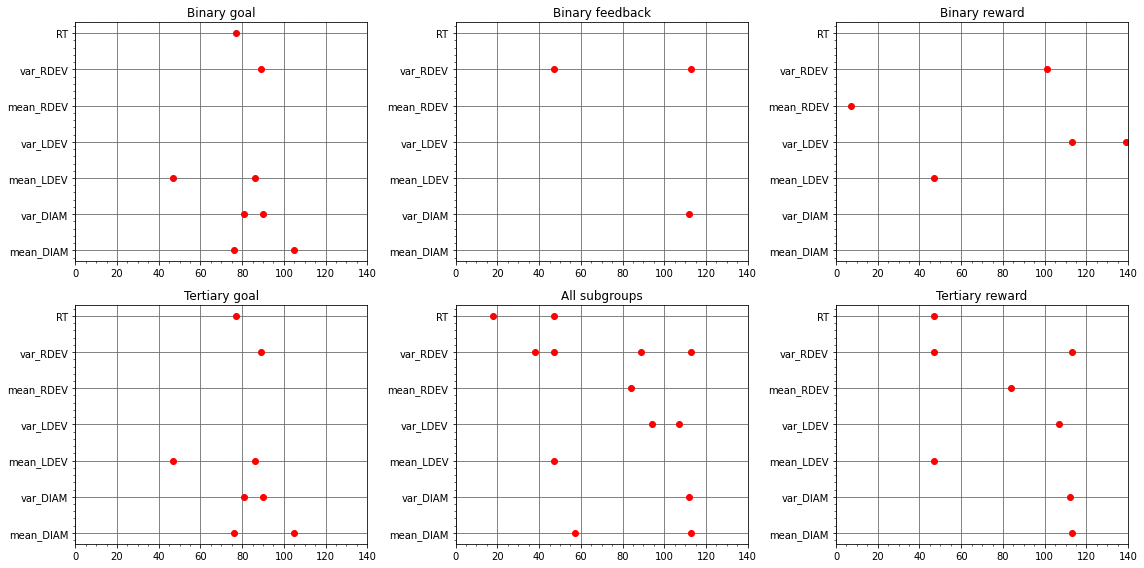

In [84]:
#Plotting the features showed
label_list = ['Binary goal','Binary feedback', 'Binary reward', 'Tertiary goal',  'Tertiary reward' , 'All subgroups', ]
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 140)
#custom_ylim = ('mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT')
     

# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim)  #, ylim=custom_ylim)

for i in range(6):
    b= dictionary_list[i]
    x, y=zip(*((int(x), k) for k in b for x in b[k]))
    if i <= 2:
        axs[0, i].plot(x, y, 'ro')
        axs[0, i].set_title(label_list[i]) 
        
    elif i ==3:
        axs[1, i-3].plot(x, y, 'ro')
        axs[1, i-3].set_title(label_list[i])
    elif i ==5:
        axs[1, 1].plot(x, y, 'ro')
        axs[1, 1].set_title(label_list[i])
        
    else:
        axs[1, 2].plot(x, y, 'ro')
        axs[1, 2].set_title(label_list[i])
        
for row in axs: 
    for ax in row: 
        ax.grid(b=True, which='major', color='#666666', linestyle='-')
        ax.minorticks_on()  
        ax.grid(b=True, which='minor', color='#999999', linestyle='--',alpha=0.01, axis = 'x')  
        

fig.tight_layout() 

plt.savefig('features for classification problem_NEW.pdf')

# scratch

In [107]:
#Reading the features and return a dictionary
def get_best_feature_names_dictionary(lasso_elasti_features): #This is for all problems
    dictionary_list = [] #the list with dictionaries for each problem
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']
    for c in range(6):
        no_of_features_list = [8,3,5,8,8,13]
        features_for_problem = lasso_elasti_features[c][0:no_of_features_list[c]] #get the correct features
        problem_dict = {new_list: [] for new_list in features}#create a dict with features as keys and empty values (a list)
        for i in range(no_of_features_list[c]): 
            f, t = get_feature_name_decomposed(features_for_problem[i])
            problem_dict[f].append(t)
        
        #Add a redundent 241 trial with all features so that all features appear on y axis in plots later (comment this part if not needed)
     
            
        dictionary_list.append(problem_dict)
    return dictionary_list

In [108]:
dictionary_list = get_best_feature_names_dictionary(lasso_elasti_features)

In [109]:
dictionary_list

[{'mean_DIAM': [105, 76],
  'var_DIAM': [90, 81],
  'mean_LDEV': [86, 47],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [89],
  'RT': [77]},
 {'mean_DIAM': [],
  'var_DIAM': [112],
  'mean_LDEV': [],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [47, 113],
  'RT': []},
 {'mean_DIAM': [],
  'var_DIAM': [],
  'mean_LDEV': [47],
  'var_LDEV': [113, 139],
  'mean_RDEV': [7],
  'var_RDEV': [101],
  'RT': []},
 {'mean_DIAM': [105, 76],
  'var_DIAM': [90, 81],
  'mean_LDEV': [86, 47],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [89],
  'RT': [77]},
 {'mean_DIAM': [113],
  'var_DIAM': [112],
  'mean_LDEV': [47],
  'var_LDEV': [107],
  'mean_RDEV': [84],
  'var_RDEV': [47, 113],
  'RT': [47]},
 {'mean_DIAM': [113, 57],
  'var_DIAM': [112],
  'mean_LDEV': [47],
  'var_LDEV': [107, 94],
  'mean_RDEV': [84],
  'var_RDEV': [47, 113, 89, 38],
  'RT': [47, 18]}]

In [ ]:
import matplotlib.pylab as plt
#x = [2,4,8,16,34,64,128]
x = range(1, 34)
y = number_dict_list[1].values()
plt.plot(x, y)
plt.axhline(y=0.5,  color='red')
plt.grid()
plt.show()


In [ ]:
#Plotting AIC and BIC
def plot_ic_criterion(model, name, color):
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure(figsize= (10, 6))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
#plt.title('Information-criterion for model selection (training time %.3fs)'
          #% t_bic)
#figure.tight_layout() 
plt.savefig('aic bic for bi_goal.pdf')

In [ ]:
best_features_methods

In [ ]:
#lasso_elasti_features[0]

In [ ]:
df = Feature_matrix_with_labels

#getting the correct features (c4, c5, c6)
import itertools
#features_for_problem = []
for i in range(1):
    no_of_features = best_features_methods[5][1] #we need features of 3,4,5 indices
    features_for_problem.append(lasso_elasti_features[5][0:no_of_features])

In [ ]:
lasso_elasti_features[0][0:no_of_features]

In [ ]:
features_for_problem = []
features_for_problem = frequent_feature_list[5][0:8]

In [ ]:
    
#Glue all the features together
features_for_problem  = list(itertools.chain(*features_for_problem) )

In [ ]:
len(features_for_problem)

In [ ]:
label_series = Feature_matrix_with_labels['label_7']  
problem_df = df.iloc[:,feature_index_list]
problem_df1 = pd.concat([problem_df, label_series], axis =1) 
problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
X = problem_df2.drop('label_7', axis =1)#get the features with the right samples
X= X.astype('float')
Y = problem_df2['label_7']
Y= Y.astype('int')

clf = SVC()
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv = cv, return_estimator=True, scoring= 'balanced_accuracy')
balanced_accuracy = cv_results['test_score'].mean()


In [ ]:
balanced_accuracy

In [ ]:
#features_for_problem1 = freq_features[1][0:11]

In [ ]:
#inconsistency check

df = Feature_matrix_with_labels 
#features_for_problem = frequent_feature_list[0][0:15] #get the correct features
feature_index_list = [x-1 for x in features_for_problem1] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
label_series = Feature_matrix_with_labels['label_7']  

problem_df = df.iloc[:,feature_index_list]
problem_df1 = pd.concat([problem_df, label_series], axis =1) 
problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
X = problem_df2.drop('label_7', axis =1)#get the features with the right samples
X= X.astype('float')
Y = problem_df2['label_7']
Y= Y.astype('int')

In [ ]:
#Getting a mean balanced score for baseline before parameter tuning

#clf = NuSVC()
clf = CalibratedClassifierCV()
#clf = GaussianNB()
#clf = SVC()
#clf = LogisticRegression()
#clf = RidgeClassifierCV()
#clf = LGBMClassifier()
#clf = LinearDiscriminantAnalysis()
#clf = NearestCentroid()
#clf = QuadraticDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
cv_results['test_score'].mean()

In [ ]:
clf = NearestCentroid(metric= 'manhattan', shrink_threshold= 0)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
cv_results['test_score'].mean()

In [ ]:
standardized_df.describe()

In [ ]:
#parameter tuning
#Nearest Centroid parameter tuning
#list the parameters I want to tune and their values
def tune_near_cent_para(X, Y):
    from sklearn.neighbors import NearestCentroid
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    distances_list = ['manhattan', 'euclidean']
    shrinkthres_list = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, None]
   #keys and values for the dictionary
    keys = []
    values = []
    for i in range(len(distances_list)):
        for j in range(len(shrinkthres_list)):
            model = NearestCentroid(metric= distances_list[i], shrink_threshold= shrinkthres_list[j] )
            keys.append(str(i)+str(j))
            cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
            cv_results = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
            accu = cv_results['test_score'].mean()
            values.append(accu)

    dict_nearestcent = dict(zip(keys, values)) 
    
    best_accuracy = max(dict_nearestcent.values())
    best_params_combo = [k for k, v in dict_nearestcent.items() if v == max(dict_nearestcent.values())]
    
    return(best_accuracy, best_params_combo )

In [ ]:
def get_stats_for_elbow_curve_new(df, feature_list):

    from sklearn.model_selection import train_test_split
    balanced_accuracy_df_list = [] #This list will have the balanced accuracy df's for the 6 problems
    from Lazy_predict_version_Nethali_new1 import Classification
    #%load_ext line_profiler
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    accuracy_dict_list = []
    aic_dict_list = []
    
    for k in range(1):
        for c in range(6):
            features_for_problem = feature_list[c]
            accuracy_dict_for_problem = {}
            aic_dict_for_problem = {}
            label_series = df[label_list[c]] 
            for j in range(len(features_for_problem)):
                feature_index_list = [x-1 for x in features_for_problem[0:j+1]] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
                balanced_accuracy_for_problem_df_list1 = [] #this is specific to a given j
                aic_for_problem_df_list2 = []
                problem_df = df.iloc[:,feature_index_list] #this needs to be changed to pick one feature at a time [0: len(feat)], the new feature matrix 7/5
                
                #This is for a particular j no of features
                
                for i in range(5): #This is for manual cv
                    random_state = [42, 35, 68, 92, 70] 
                    #random_state = [42, 35, 68, 92, 80] 
                   
                    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
                    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
                    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
                    X= X.astype('float')
                    
                    Y = problem_df2[label_list[c]]
                    Y= Y.astype('int')
                    
                    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
                    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
                    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
                    balanced_accuracy_for_problem_df_list1.append(models.drop(['AIC', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"Accuracy":str(i)}))
                    aic_for_problem_df_list2.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"AIC":str(i)}))
                #get the resulting concat df
                result_df1 = pd.concat(balanced_accuracy_for_problem_df_list1, axis=1)
                result_df2 = pd.concat(aic_for_problem_df_list2, axis=1)
                #get the lowest median for df2 and highest accuracy for df1
                accuracy_dict_for_problem[str(j+1)+'features'] = (result_df1.median(axis= 1).max(), 
                                                                result_df1.median(axis= 1).idxmax())
                aic_dict_for_problem[str(j+1)+'features'] = (result_df2.median(axis= 1).min(), 
                                                                result_df2.median(axis= 1).idxmin())
            accuracy_dict_list.append(accuracy_dict_for_problem)
            aic_dict_list.append(aic_dict_for_problem)
    return accuracy_dict_list , aic_dict_list 